# Chess in Python

Here I'll be working towards creating a chess engine using deep learning.

## Simulating Chess Matches

I want to start off by creating a chess match simulator. This will be what the engine will interact with in order to train. First thing we do here is import the necessary packages and demonstrate a bit of how they work.

In [1]:
import itertools as it

import chess
import chess.pgn

In [2]:
game = chess.pgn.Game()
board = game.board()

In [3]:
game.headers

OrderedDict([('Event', '?'),
             ('Site', '?'),
             ('Date', '????.??.??'),
             ('Round', '?'),
             ('White', '?'),
             ('Black', '?'),
             ('Result', '*')])

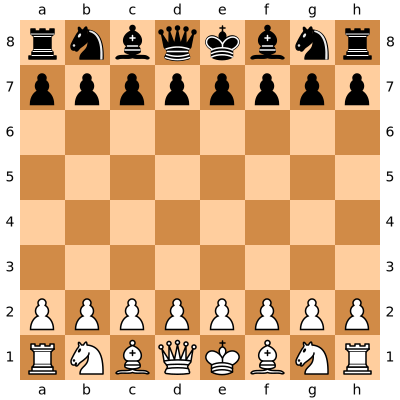

In [4]:
board

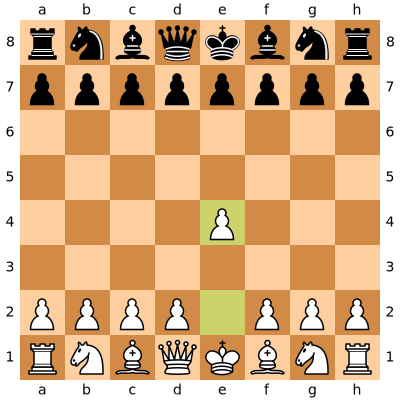

In [5]:
board.push(chess.Move.from_uci("e2e4"))
board

In [6]:
board.reset_board()

Pretty straightforward. Next we create a program that simulates random chess games where the moves are selected uniformly at random.

In [7]:
def get_current_time():
    from datetime import datetime
    return datetime.strftime(datetime.now(), "%Y/%m/%d %H:%M:%S.%f")

def initialise_game():
    game = chess.pgn.Game()
    board = game.board()
    game.headers['Date'] = get_current_time()
    game.headers['Black'] = 'Random Agent'
    game.headers['White'] = 'Random Agent'
    return game, board

def simulate_game():
    
    def get_next_move():
        from random import sample
        return sample(list(board.legal_moves), 1)[0]
        
    game, board = initialise_game()
    next_move = get_next_move()
    node = game.add_variation(next_move)
    board.push(next_move)
    while not board.is_game_over():
        next_move = get_next_move()
        node = node.add_variation(next_move)
        board.push(next_move)
    
    game.headers['Result'] = board.result()
    
    return game, board

[Event "?"]
[Site "?"]
[Date "2017/11/26 20:55:12.828357"]
[Round "?"]
[White "Random Agent"]
[Black "Random Agent"]
[Result "1/2-1/2"]

1. a4 d6 2. Nf3 Nf6 3. Ng5 Nc6 4. f4 Ng4 5. a5 Nd4 6. Ra2 Nb5 7. d4 e6 8. Ne4 Na3 9. Nxa3 f6 10. b3 Kd7 11. Nc3 Ke8 12. Nab5 f5 13. Nxd6+ Bxd6 14. Ra3 Bd7 15. Rg1 Nh6 16. Be3 g5 17. fxg5 Rg8 18. Bc1 Rc8 19. Nb1 Rf8 20. b4 Bb5 21. g6 Ba4 22. gxh7 Qg5 23. Qd3 Ra8 24. e4 Bxh2 25. Nd2 Ke7 26. g3 Rf7 27. h8=B Rd8 28. g4 Bd6 29. Bg2 Re8 30. Bf6+ Rxf6 31. Qe2 Kd8 32. Nf3 Rg8 33. Qf2 Be5 34. Bd2 Rff8 35. Qf1 Qh4+ 36. Nxh4 Bg7 37. Nxf5 Bh8 38. Nxh6 Ke7 39. Ra1 Bc6 40. Ra3 Rg6 41. Kd1 Rxf1+ 42. Bxf1 Rg8 43. Bc3 Bb5 44. Be1 Be5 45. Ra4 c5 46. Ra3 Ba6 47. Rf3 Rxg4 48. Nxg4 b5 49. Bf2 Bh8 50. Rg2 Kd7 51. Bg1 cxb4 52. Ke2 Kc7 53. Kd2 Bb7 54. Rfg3 Bc8 55. Rb3 Bb7 56. a6 Be5 57. Rc3+ Kb6 58. Rc5 Ba8 59. Bc4 Bc6 60. Rxb5+ Kc7 61. Ba2 Bd6 62. Be3 Bb7 63. Ra5 b3 64. Rc5+ Kb6 65. Rc8 Kb5 66. Nh6 Ba3 67. Rc7 Ba8 68. Rgg7 Bb7 69. e5 Bf8 70. Rg8 Be4 71. Kd1 Bd3 72. Rc6 Bf5 

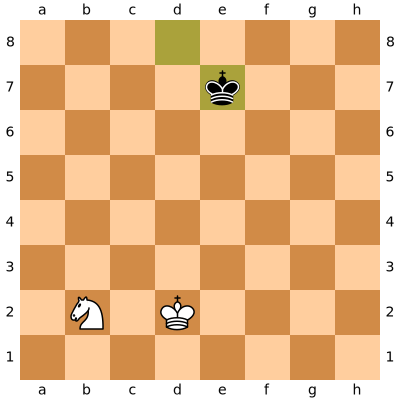

In [8]:
game, board = simulate_game()
print(game)
board

## Featurising Chess

Now that we can successfully simulate a random chess game, the next job is to turn the board position into a set of features that can be fed into a machine learning algorithm. In this part, I will take inspiration from the AlphaGo Zero model.

In [9]:
import numpy as np

We want to one-hot encode the positions of each piece on the board. As the package is written, board positions are stored using 64 bit integers. In order to repackage the board positions as a numpy array, we need to write a function to convert them.

In [10]:
def int_to_mask(squares):
    '''Takes a set of squares as an integer and returns an 8x8 matrix of the marked squares'''
    # convert int to binary
    squares = np.binary_repr(squares, width=64)
    # break int string into one-hot array
    squares = np.array([i for i in squares])
    # reshape into 8 by 8 matrix
    squares = squares.reshape(8,8)
    # flip along y axis (for some reason)
    squares = squares[:,::-1]
    # change type to int
    squares = squares.astype(np.int0)
    return squares

Now we can use `int_to_mask` to express where each piece on the board is as a numpy array.

In [11]:
int_to_mask(board.pieces_mask(color=chess.BLACK, piece_type=chess.KING))

array([[0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0]], dtype=int64)

We compare our result with the board below.

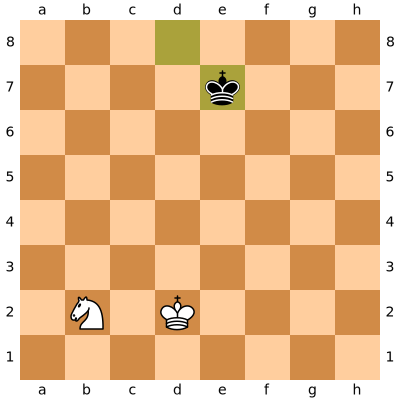

In [12]:
board

## Featurising the board position

In order to create features for the deep learning model, we will arrange the board position as a stack of `8 x 8` arrays. We will create one-hot encoded layers for each unique piece type and colour. The order of the first 12 layers will be as follows:

- White Pawn
- White Knight
- White Bishop
- White Rook
- White Queen
- White King

- Black Pawn
- Black Knight
- Black Bishop
- Black Rook
- Black Queen
- Black King

We can repeat this stack 4 times to store the past few moves on the board. This will be necessary to give the model the ability to detect 'En Passant'.

We will also add one more layer to indicate which rooks on the board are still capable of castling. And one last layer to indicate if it is the white player's turn.

That makes `12 x 4 + 2 = 50` layers over all, totalling `3200` input values.

## Building the Feature Matrix

Now I'll write the code to build the first `14` layers of the model from the game board.

In [13]:
input_data = np.zeros(shape = (14, 8, 8))
for i, colour in enumerate(chess.COLORS):
    for j, piece in enumerate(chess.PIECE_TYPES):
        k = i * len(chess.PIECE_TYPES) + j
        input_data[k, :, :] = int_to_mask(board.pieces_mask(color=colour, piece_type=piece))
        print(input_data[k, :, :])
        print()

[[ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]]

[[ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]]

[[ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]]

[[ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. 

Next we add the castling information:

In [14]:
input_data[k + 1, :, :] = int_to_mask(board.castling_rights)
input_data[k + 1, :, :]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

And lastly whose turn it is.

In [15]:
input_data[k + 2, :, :] = board.turn * np.ones((8, 8))
input_data[k + 2, :, :]

array([[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]])

Now we package these operations into a function that can generate the feature matrix for a given board.

In [16]:
def featurise_board(board):
    board_data = np.zeros(shape = (12, 8, 8))
    for i, colour in enumerate(chess.COLORS):
        for j, piece in enumerate(chess.PIECE_TYPES):
            k = i * len(chess.PIECE_TYPES) + j
            piece_location = board.pieces_mask(color=colour, piece_type=piece)
            board_data[k, :, :] = int_to_mask(piece_location)
    return board_data

## Defining the Forward Pass

Now that we have a sensible feature set, we have to create a model architecture, and then perform a forward pass with a random initialisation to make sure that the model output is well defined. Ideally, we would like to implement a Deep Residual Network. 

Once we have that, we will be able to start working on the Markov Chain Monte Carlo (MCMC) Tree Search implementation, and also the training loop for the model.

Some useful resources:
- https://codesachin.wordpress.com/2017/02/19/residual-neural-networks-as-ensembles/
- https://blog.waya.ai/deep-residual-learning-9610bb62c355

## What is a Move?

Before we can define the forward pass, we have define our target output. We want the model to map board positions to moves on the board, so we need a way to express what a particular move on the board looks like to the neural network.

All moves in chess are performed by selecting a piece, and moving it to a new square. At the same time that a piece is moved, there can be side-effects on the board (e.g. a piece capture, or another piece may move as in castling). This means that the target output can simply be a selection of a piece in one location, along with the target location where the piece has been moved.

This means we can represent moves via an `64 x 64 = 4096` array where moves are given as ordered pairs of squares on the board (i.e. a 'from' square to select the piece on that square and a 'target' square to select where the piece is moving).

However, we also need to add 4 more output parameters as well to describe pawn promotion. This is because when a pawn promotes to the other side of the board, the model will need to select which piece (Queen, Rook, Bishop or Knight) the AI will choose to replace the pawn. This makes for `5000` output parameters, which is quite a lot more than I would have expected.

If I can think of ways to simplify the output parameter space later, then I will. This large search space strikes me as unparsimonious.

## Coding Move Selection

Here I'll be writing the code that constructs a representation of each possible move on the board. The trick here is to do this based on the `uci` for each move.

In [17]:
# initialise the target values
move_data = np.zeros((8, 8, 8, 8))
move_data.shape

(8, 8, 8, 8)

In [18]:
def uci_to_matrix(uci):
    move_data = np.zeros((8, 8, 8, 8))
    letters = dict(zip('abcdefgh', range(8)))
    i, j, k, l = [letters[ch] if ch in letters else int(ch) for ch in uci]
    move_data[i, j, k, l] = 1
    return move_data

There is still the question of how to represent pawn promotion. In order to find out how `move.uci()` does it, I'll create a fresh board and promote a pawn in order to find out what happens.

In [19]:
board.clear_board()
board.set_piece_at(square = chess.H7,
                   piece = chess.Piece(chess.PAWN, chess.WHITE))
legal_moves = list(board.legal_moves)
legal_moves

[Move.from_uci('h7h8q'),
 Move.from_uci('h7h8r'),
 Move.from_uci('h7h8b'),
 Move.from_uci('h7h8n')]

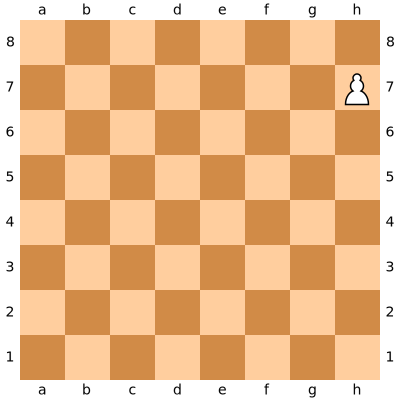

In [20]:
board

This shows us how `uci` represents pawn promotion. So all we have to do is modify the `uci_to_matrix` function to make sure this is represented as well.

In [21]:
def uci_to_array(uci):
    move_data = np.zeros((8, 8, 8, 8))
    prom_data = np.zeros(4)
    
    if len(uci) == 5:
        # handle pawn promotion
        prom_dict = dict(zip('qrbn', range(4)))
        prom_piece = prom_dict[uci[-1]]
        prom_data[prom_piece] = 1
        uci = uci[:-1]
    
    # record piece movement
    letters = dict(zip('abcdefgh', range(8)))
    i, j, k, l = [letters[ch] if ch in letters else int(ch) - 1 for ch in uci]
    move_data[i, j, k, l] = 1
    
    return move_data, prom_data

In [22]:
dict(zip('abcdefgh', range(8)))

{'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7}

In [23]:
move_uci = legal_moves[0].uci()
move_data, prom_data = uci_to_array(move_uci)
move_uci

'h7h8q'

In [29]:
prom_data

array([ 1.,  0.,  0.,  0.])

In [30]:
for i, j in it.product(range(8), range(8)):
    data = move_data[i, j, :, :]
    if np.sum(data) == 1:
        print(i, j)
        print(data)

7 6
[[ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.]]


In [31]:
for i, j in it.product(range(8), range(8)):
    data = move_data[:, :, i, j]
    if np.sum(data) == 1:
        print(i, j)
        print(data)

7 7
[[ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.]]


We also need to create the inverse map as well:

In [32]:
def array_to_uci(move_data, prom_data):
    i, j, k, l = np.transpose(np.nonzero(move_data))[0]
    letters = dict(zip(range(8), 'abcdefgh'))
    prom_dict = dict(zip(range(4), 'qrbn'))
    prom_piece = prom_dict[np.argmax(prom_data)]
    return letters[i] + str(j + 1) + letters[k] + str(l + 1) + prom_piece

In [33]:
array_to_uci(move_data, prom_data), move_uci

('h7h8q', 'h7h8q')

It works!

## Defining the Network Architecture

Now that we've gotten this far, it's time to have a go at creating an architecture that creates the output that we need in order to run the model.

The model architecture code is largely pulled from here, but the ideas are from the DeepMind paper:

https://blog.waya.ai/deep-residual-learning-9610bb62c355

In [34]:
import tensorflow as tf

Here the idea is to follow the DeepMind paper closely (but with a smaller network overall). The AlphaGo Zero model consists of a single convolutional block followed by a sequence of residual blocks.

The convolutional block applies the following modules:
- A convolution of `256` filters of kernel size `3 × 3` with stride `1`
- Batch normalization
- A rectifier nonlinearity

Each residual block applies the following modules sequentially to its input:
- A convolution of `256` filters of kernel size `3 × 3` with stride `1`
- Batch normalization
- A rectifier nonlinearity
- A convolution of `256` filters of kernel size `3 × 3` with stride `1`
- Batch normalization
- A skip connection that adds the input to the block
- A rectifier nonlinearity

In [35]:
def convolutional_block(y, nb_channels, _strides=(1, 1)):
    y = layers.Conv2D(nb_channels, kernel_size=(3, 3), strides=_strides, padding='same')(y)
    y = layers.BatchNormalization()(y)
    y = layers.LeakyReLU()(y)

def residual_block(y, nb_channels, _strides=(1, 1), _project_shortcut=False):
    shortcut = y

    # down-sampling is performed with a stride of 2
    y = layers.Conv2D(nb_channels, kernel_size=(3, 3), strides=_strides, padding='same')(y)
    y = layers.BatchNormalization()(y)
    y = layers.LeakyReLU()(y)

    y = layers.Conv2D(nb_channels, kernel_size=(3, 3), strides=(1, 1), padding='same')(y)
    y = layers.BatchNormalization()(y)

    # identity shortcuts used directly when the input and output are of the same dimensions
    if _project_shortcut or _strides != (1, 1):
        # when the dimensions increase projection shortcut is used to match dimensions (done by 1×1 convolutions)
        # when the shortcuts go across feature maps of two sizes, they are performed with a stride of 2
        shortcut = layers.Conv2D(nb_channels, kernel_size=(1, 1), strides=_strides, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    y = layers.add([shortcut, y])
    y = layers.LeakyReLU()(y)

    return y

The output of the residual tower is passed into two separate ‘heads’ for
computing the policy and value. The policy head applies the following modules:
- A convolution of `2` filters of kernel size `1 × 1` with stride `1`
- Batch normalization
- A rectifier nonlinearity
- A fully connected linear layer that outputs a vector of size `192 + 1 = 362`,
corresponding to logit probabilities for all intersections and the pass move

For the last layer, we instead replace it with the target shape that we determined earlier.

In [36]:
def policy_head(y, nb_channels, _strides=(1, 1)):
    y = layers.Conv2D(nb_channels, kernel_size=(3, 3), strides=_strides, padding='same')(y)
    y = layers.BatchNormalization()(y)
    y = layers.LeakyReLU()(y)
    y = layers.Dense(units = 5000)
    return y

The value head applies the following modules:
- A convolution of `1` filter of kernel size `1 × 1` with stride `1`
- Batch normalization
- A rectifier nonlinearity
- A fully connected linear layer to a hidden layer of size `256`
- A rectifier nonlinearity
- A fully connected linear layer to a scalar
- A tanh nonlinearity outputting a scalar in the range `[−1, 1]`

In [37]:
def value_head(y, nb_channels, _strides=(1, 1)):
    y = layers.Conv2D(nb_channels, kernel_size=(3, 3), strides=_strides, padding='same')(y)
    y = layers.BatchNormalization()(y)
    y = layers.LeakyReLU()(y)
    y = layers.Dense(units = 256, activation = 'ReLU')
    y = layers.LeakyReLU()(y)
    y = layers.Dense(units = 1, activation = 'tanh')
    return y

The architecture should look something like this with some simple modifications. Before I proceed, I should make sure that this architecture works properly. Then I can work out how to train the model.

## Doing Calculations in TensorFlow

Now I need to wrap my head around how calculations in TensorFlow work. Once I can do this, I should be able to verify that my Residual Network Architecture is well defined.

Below is a simple calculation example in an interactive session:

In [38]:
sess = tf.InteractiveSession()
a = tf.constant(5.0)
b = tf.constant(6.0)
c = a * b
# We can just use 'c.eval()' without passing 'sess'
print(c.eval())
sess.close()

30.0


### Creating Input Values

In [39]:
game, board = initialise_game()

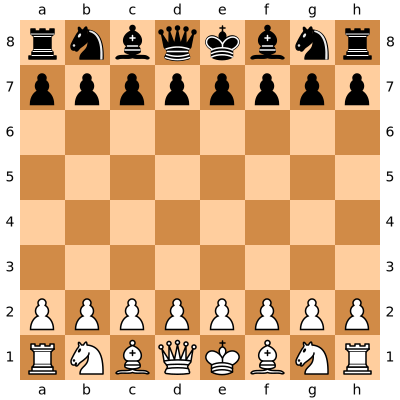

In [40]:
board

In [41]:
from keras import layers

Using TensorFlow backend.


In [42]:
input_data = featurise_board(board)
input_data = input_data.reshape(1, 12, 8, 8)
input_data = input_data.astype(np.float32)

In [43]:
def convolutional_block(X, nb_channels = 256, kernel_size = (3, 3), 
                        strides = (1, 1), activation = True):
    y = layers.Conv2D(filters = nb_channels, kernel_size = kernel_size, 
                      data_format = 'channels_first',
                      strides = strides, padding='same')(X)
    y = tf.layers.batch_normalization(y)
    if activation:
        y = tf.nn.relu(y)
    return y

In [48]:
def convolutional_block(X, filters = 256, kernel_size = (3, 3), activation = 'relu'):
    '''
    The convolutional block for the network. Performs convolution with a given number
    of filters and kernel size.

    If an activation is given, then it will be applied to the output before the
    result is returned. If you want no activation function, then use activation = None'''

    # run y through convolutional layer
    y = layers.Conv2D(
            filters = filters, 
            kernel_size = kernel_size,
            data_format = 'channels_first',
            padding='same')(X)

    # Apply batch normalisation
    y = tf.layers.batch_normalization(y)
    if activation:
        # Apply activation function
        y = tf.nn.relu(y)

    # return output tensor
    return y

In [49]:
sess = tf.InteractiveSession()
X = tf.convert_to_tensor(input_data)
y = convolutional_block(X)
tf.global_variables_initializer().run()
output = y.eval()
sess.close()

In [50]:
output.shape

(1, 256, 8, 8)

This proves that the convolutional block is working and well defined. Now we can move on to the residual block.

In [ ]:
def residual_block(X, nb_channels):
   
    y = convolutional_block(X)
    y = convolutional_block(y, activation = False)
    X = convolutional_block(X, kernel_size = (1, 1), activation = False)
    y = tf.nn.relu(X + y)

    return y

In [ ]:
sess = tf.InteractiveSession()
y = tf.convert_to_tensor(output)
y = residual_block(y, nb_channels=256)
tf.global_variables_initializer().run()
print(y.eval().shape)
sess.close()

And now I need to define the policy and value heads for the network architecture.

In [ ]:
def policy_head(y, _strides=(1, 1)):
    y = convolutional_block(y, activation = True)
    y = layers.Flatten()(y)
    y = layers.Dense(units = 5000)(y)
    y = layers.Activation('softmax')(y)
    return y

In [ ]:
sess = tf.InteractiveSession()
y = policy_head(y)
tf.global_variables_initializer().run()
print(y.eval().shape)
sess.close()

Time for the value head:

In [ ]:
def value_head(y, _strides=(1, 1)):
    y = convolutional_block(y)
    y = layers.Flatten()(y)
    y = layers.Dense(units = 256, activation = 'relu')(y)
    y = layers.Dense(units = 1, activation = 'tanh')(y)
    return y

In [ ]:
sess = tf.InteractiveSession()
y = value_head(y)
tf.global_variables_initializer().run()
value = y.eval()
print(value.shape)
sess.close()

In [ ]:
value[0][0]

This is a successful forward pass. Now I can wrap this into a single operation and start figuring out how to create the training loop.

In [60]:
from keras import layers

def residual_tower(X, num_blocks = 10, filters = 256):
    '''
    Constructs a residual tower consisting of a convolutional block, followed
    by a sequence of `num_blocks` residual blocks, each of with a fixed number of
    filters.
    
    The residual tower output is passed to the policy + value heads for
    move prediction and board evaluation respectively'''
    
    def convolutional_block(X, filters = filters, kernel_size = (3, 3), activation = True):
        '''
        The convolutional block for the network. Performs convolution with a given number
        of filters and kernel size.
        
        If an activation is given, then it will be applied to the output before the
        result is returned. If you want no activation function, then use activation = None'''
        
        # run y through convolutional layer
        y = layers.Conv2D(
                filters = filters, 
                kernel_size = kernel_size,
                data_format = 'channels_first',
                padding='same')(X)
        
        # Apply batch normalisation
        y = tf.layers.batch_normalization(y)
        if activation:
            # Apply activation function
            y = tf.nn.relu(y)
        
        # return output tensor
        return y
    
    def residual_block(X, activation = 'relu'):
        y = convolutional_block(X)
        y = convolutional_block(y, activation = None)
        X = convolutional_block(X, kernel_size = (1, 1), activation = None)
        y = tf.nn.relu(X + y)
        return y
    
    ## Define Residual Tower:
    y = convolutional_block(X)
    for i in range(num_blocks):
        y = residual_block(y)
    return y

def policy_head(y):
    y = convolutional_block(y, activation = True)
    y = layers.Flatten()(y)
    y = layers.Dense(units = 5000)(y)
    y = layers.Activation('softmax')(y)
    return y

def value_head(y):
    y = convolutional_block(y)
    y = layers.Flatten()(y)
    y = layers.Dense(units = 256, activation = 'relu')(y)
    y = layers.Dense(units = 1, activation = 'tanh')(y)
    return y

In [71]:
sess = tf.InteractiveSession()
X = tf.convert_to_tensor(input_data)
y = residual_tower(X)
tf.global_variables_initializer().run()
# policy = policy_head(y).eval()
# value = value_head(y).eval()
output = y.eval()
sess.close()

In [72]:
output.shape

(1, 256, 8, 8)

In [63]:
policy

<tf.Tensor 'activation_4/Softmax:0' shape=(?, 5000) dtype=float32>

In [64]:
value

<tf.Tensor 'dense_6/Tanh:0' shape=(?, 1) dtype=float32>